In [37]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # specify which GPU(s) to be used

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [42]:
import sys
sys.path.append('../')

from pathlib import Path 
import pickle
import argparse
import glob
import logging
import os
import random
import timeit
import pickle
import sys
import numpy as np
from tqdm import tqdm, trange

import time
from collections import defaultdict
from spacy.lang.en import English
import collections

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss

from transformers import (
    BertPreTrainedModel,
    AutoModelForQuestionAnswering,
    AutoModel,
    AdamW,
    AutoConfig,
    AutoTokenizer,
    get_linear_schedule_with_warmup
)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE, MDS
from sklearn import metrics

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter


logger = logging.getLogger()
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

path_data = "/net/kdinxidk03/opt/NFS/75y/data/"
output_dir = "/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/"

# path_bioasq_6b_train = Path(path_data+"qa/data/BioASQ-6b/train/Appended-Snippet/BioASQ-train-factoid-6b-snippet-2sent.json")

# path_squad_train = Path(path_data+"squad/train-v2.0.json")


In [4]:
input_dir = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/'

In [96]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    uniq = unique_labels(y_true, y_pred)
    classes = np.array(classes)[uniq]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(4, 4))
    ax = plt.subplot(111)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # And label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
    ax.legend(loc='best')
    return ax

print(__doc__)

# colors = ['royalblue', 'darkorange', 'green', 'purple', 'red', 'yellow', 'pink', 'brown', 'gray', 'black']
colors = ['blue', 'green',  'orange', 'b', 'darkorange', 'orange', 'green', 'purple', 'red', 'yellow', 'pink', 'brown', 'gray', 'black']

def make_ellipses(gmm, ax, clusters_to_classes):
    """
    Adds Ellipses to ax according to the gmm clusters.
    """
    for n in sorted(list(clusters_to_classes.keys())):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        class_id = clusters_to_classes[n]
        class_color = colors[class_id]
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=class_color, linewidth=0) 
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.3)
        ax.add_artist(ell)
#         ax.set_aspect('equal', 'datalim')

def map_clusters_to_classes_by_majority(y_train, y_train_pred):
    """
    Maps clusters to classes by majority to compute the Purity metric.
    """
    cluster_to_class = {}
    for cluster in np.unique(y_train_pred):
        # run on indices where this is the cluster
        original_classes = []
        for i, pred in enumerate(y_train_pred):
            if pred == cluster:
                original_classes.append(y_train[i])
        # take majority         
        cluster_to_class[cluster] = max(set(original_classes), key = original_classes.count)
    return cluster_to_class

  
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 
  
def fit_gmm(eps, n_init, max_iter, eps_mds, min_samples, name_to_embeddings, class_names, first_principal_component_shown=0, 
            last_principal_component_shown=1, clusters=2, header='', plot=True, ellipse=True, 
            pca=True, confusion=False, ex_per_cls = None, plot_n=None, pca_data=None):
    """
    Fits a GMM to the embeddings in name_to_embeddings where each name represents a dataset.
    """
    all_states = []
    num_classes = len(class_names)
    if last_principal_component_shown <= first_principal_component_shown:
        raise Exception('first PCA component must be smaller than the 2nd')


    pca_labels = []
    for i in range(len(class_names)):
        for j in range(ex_per_cls[i]):
            pca_labels.append(i)
    pca_labels = np.array(pca_labels)

    # Concatenate the data to one matrix
    for i in range(len(class_names)):
        all_states.append(name_to_embeddings[class_names[i]][0:ex_per_cls[i]])
    concat_all_embs = np.concatenate(all_states)
    
    if pca_data is None:

  #     from scipy.stats import multivariate_normal
  #     x = name_to_embeddings[class_names[0]][0:ex_per_cls[0]]
  #     y = multivariate_normal.pdf(np.array(x), mean=(np.array(x)).mean(axis=0),
  #                                 cov=np.cov(np.transpose(np.array(x))),
  #                                 allow_singular=True
  #                                )
  #     fig1 = plt.figure()
  #     ax = fig1.add_subplot(111)
  #     ax.plot(x, y)

  #     # Concatenate the data to one matrix
  #     for label in class_names:
  #         all_states.append(name_to_embeddings[label][0:examples_per_class])
  #     concat_all_embs = np.concatenate(all_states)

      # Compute PCA
      import sklearn
      if pca:
          pca = TSNE(n_components=2, random_state=42)
#           pca = PCA(n_components=2, random_state=42) #1+last_principal_component_shown)
#           dist_cosine = sklearn.metrics.pairwise.cosine_distances(concat_all_embs)
#           print('dist_cosine.shape:', dist_cosine.shape)
#           mds = MDS(n_components=2,   ## 7b,9b
#                     dissimilarity='precomputed', 
#                     metric=True,
#   #                   n_init=10, 
#                     n_init=n_init,
#   #                   max_iter=50, #7b, 8b  
#                     max_iter=max_iter, #9b
#                     verbose=0, 
#   #                   eps=0.25,#7b
#   #                   eps=0.2, #8b
#                     eps=eps_mds,     #9b
#                     n_jobs=10, 
#                     random_state=0)
#   #         mds = MDS(n_components=2,    ## 8b
#   #                   dissimilarity='precomputed', 
#   #                   metric=True,
#   #                   n_init=10, 
#   #                   max_iter=50, 
#   #                   verbose=0, 
#   #                   eps=0.5, 
#   #                   n_jobs=10, 
#   #                   random_state=0)        
#           pca_data = mds.fit_transform(dist_cosine)
  #         pca = KernelPCA(n_components=2, kernel='cosine',random_state=42) #1+last_principal_component_shown)
          pca_data = pca.fit_transform(concat_all_embs)[:, 
                                                        list(range(first_principal_component_shown,
                                                                   last_principal_component_shown+1))
                                                       ]
      else:
          pca_data = concat_all_embs

      print('MDS completed . . . .')

    # Do not split the data - train=test=all (unsupervised evaluation) 
    train_index = list(range(0, pca_data.shape[0]))
    test_index = list(range(0, pca_data.shape[0]))

    X_train = pca_data[train_index]
    y_train = pca_labels[train_index]
    X_test = pca_data[test_index]
    y_test = pca_labels[test_index]
    
    print(X_train.shape, X_test.shape)

    n_classes = len(np.unique(y_train))
    if clusters > 0:
        n_clusters = clusters
    else:
        n_clusters = n_classes
    
    # Can try GMMs using different types of covariances, we use full.
#     estimator = AffinityPropagation(random_state=42)
#     estimator = GaussianMixture(n_components=n_clusters, random_state=42)
#     estimator = KMeans(n_clusters, random_state=42)
#     estimator = DBSCAN(eps=0.005, min_samples=20, metric='cosine') ## 9b
    estimator = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine') ## 7b
#     estimator = DBSCAN(eps=0.05, min_samples=20, metric='cosine') ## 8b

#   GaussianMixture(n_components=n_clusters, random_state=42)
#     estimators = {cov_type: GaussianMixture(n_components=n_clusters,
#                   covariance_type=cov_type, max_iter=150, random_state=0)
#                   for cov_type in ['full']} #'spherical', 'diag', 'tied', 

#     n_estimators = len(estimators)

    # Configure the plot
    if plot:
        plt.figure(figsize=(5,5))
        plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05, left=.01, right=.99)

    best_accuracy = 0
#     for index, (name, estimator) in enumerate(estimators.items()):

#     # train the GMM         
#     estimator.fit(X_train)

          
    print('DBSCAN completed . . . .')

#     print(np.unique(estimator.labels_))
#     print(estimator.cluster_centers_)

    # create the plots
    if plot:
      h = plt.subplot(111)

#       Plot the train data with dots
#       label_names = ['cpgQA', 'emrQA', 'BioASQ']
      label_names = ['clinical practice guidelines (cpgQA)',
                     'clinical notes (emrQA)',
                     'scholarly articles (BioASQ)']

      alphas = [0.3, 0.3, 0.3]
      for n, color in enumerate(colors[:n_classes]):
          data = pca_data[[idx for idx in range(len(pca_labels)) if pca_labels[idx] == n]]
          print('data.shape: ', data.shape)
          if data.shape[1] != 1:
              sns.scatterplot(data[:plot_n, 0], data[:plot_n, 1],
                              s=120, marker='o',
#                               hue=color,
                              linewidths = 0,
                              label=label_names[n], alpha = alphas[n])
#           else:
#               plt.scatter(plot_n, data[:plot_n, 0],
#   #                     range(data.shape[0]), data[:, 0], 
#                           s=80, marker='o', color=color, linewidths = 0,
#                           label=class_names[n], alpha = 0.2)


      plt.legend(loc='best', prop={'size': 13})
      plt.xticks(size=12)
      plt.yticks(size=12)
      plt.xlabel('PCA Component 1', size=15)
      plt.ylabel('PCA Component 2', size=15)
#       plt.grid(True)
#       xlimit = 1.2
#       ylimit = 1.2
#       plt.xlim(-100, 100)
      plt.ylim(-75, 125)
      
      
#       h = plt.subplot(121)
#       for n, color in enumerate(colors[:n_classes]):
#           data = pca_data[[idx for idx in range(len(pca_labels)) if pca_labels[idx] == n]]
#           print('data.shape: ', data.shape)
#           if data.shape[1] != 1:
#               plt.scatter(data[:plot_n, 0], data[:plot_n, 1], 
#                           s=80, marker='o', color=color, linewidths = 0,
#                           label=class_names[n], alpha = 0.6)
# #           else:
# #               plt.scatter(plot_n, data[:plot_n, 0],
# #   #                     range(data.shape[0]), data[:, 0], 
# #                           s=80, marker='o', color=color, linewidths = 0,
# #                           label=class_names[n], alpha = 0.2)


#       plt.legend(loc='best', prop={'size': 15})
#       plt.xticks(size=12)
#       plt.yticks(size=12)
#       plt.xlabel('component 1', size=15)
#       plt.ylabel('component 2', size=15)
#       plt.grid(True)
      
      

#       # predict the cluster ids for train         
#       y_train_pred = estimator.fit_predict(X_train)

#       # predict the cluster ids for test
#       y_test_pred = estimator.fit_predict(X_test)
      
      from collections import Counter
      
#       print('PRED: ', Counter(y_test_pred))


#       print('Accuracy:', metrics.accuracy_score(y_train, y_train_pred))

#       dist_cosine_mds = sklearn.metrics.pairwise.cosine_distances(X_test)

#       if len(np.unique(y_train_pred)) != 1:
#         print('Silhouette', metrics.silhouette_score(
# #                                                     dist_cosine_mds,
#                                                      X_test,
#                                                      y_test_pred,
#                                                      metric='cosine',
#                                                      random_state=0))
#         print('Accuracy:', metrics.accuracy_score(y_test, y_test_pred))
        
#         y_test_pred_1 = [1-x for x in y_test_pred]
#         print('Accuracy Reversed:', metrics.accuracy_score(y_test, y_test_pred_1))

        
# #         print('ACC TRAIN: ', purity_score(y_train, y_train_pred))
# #         print('ACC TEST : ', purity_score(y_test, y_test_pred))

#       # map clusters to classes by majority of true class in cluster         
#       clusters_to_classes = map_clusters_to_classes_by_majority(y_train, y_train_pred)

#       # plot confusion matrix, error analysis         
#       if confusion and len(np.unique(y_train_pred)) != 1:
#           from spacy.tokenizer import Tokenizer
#           from spacy.lang.en import English
#           nlp = English()
#           # Create a blank Tokenizer with just the English vocab
#           tokenizer = Tokenizer(nlp.vocab)
#           digits_counter = defaultdict(int)
#           digits_counter_pred = defaultdict(int)
#           count_num_errors = 0
#           count_errors = 0
#           subs_prons = 0
#           subs_erros = 0
#           subs_prons_overall = 0
#           sent_lens = []
#           y_pred_by_majority = np.array([clusters_to_classes[pred] for pred in y_train_pred])
#           y_train_pred = np.array([x if x in [0,1] else -1 for x in y_train_pred])
# #           plot_confusion_matrix(y_train, y_train_pred,
# # #                                 np.unique(estimator.labels_),
# #                                 class_names,
# #                                 title = header)

#       # Calculate the Purity metric         
#       count=0
#       for i, pred in enumerate(y_train_pred):
#           if clusters_to_classes[pred] == y_train[i]:
#               count += 1
#       train_accuracy = float(count)/len(y_train_pred) * 100

#       correct_count=0
#       for i, pred in enumerate(y_test_pred):
#           if clusters_to_classes[pred] == y_test[i]:
#               correct_count += 1
#       test_accuracy = float(correct_count)/len(y_test_pred) * 100

#       if test_accuracy > best_accuracy:
#           best_accuracy = test_accuracy

#       if ellipse and plot:
#           make_ellipses(estimator, h, clusters_to_classes)

#           leg = plt.legend(scatterpoints=1, 
#                            loc='lower right', 
#                            prop=dict(size=18))
#           for lh in leg.legendHandles: 
#               lh.set_alpha(1)
#               lh._sizes = [60]

    if plot:        
      plt.suptitle(header)
#       main_plot.savefig("/home/nlp/aharonr6/git/focus/main.pdf", bbox_inches='tight')

      plt.show()

    return best_accuracy, pca_data, pca_labels



Automatically created module for IPython interactive environment


In [6]:
def features_to_dataset(features, is_training=False):
    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_masks = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
    all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)
    all_is_impossible = torch.tensor([f.is_impossible for f in features], dtype=torch.float)

    if not is_training:
        all_feature_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
        dataset = TensorDataset(
            all_input_ids, all_attention_masks, all_token_type_ids, all_feature_index, all_cls_index, all_p_mask
        )
    else:
        all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
        all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
        dataset = TensorDataset(
            all_input_ids,
            all_attention_masks,
            all_token_type_ids,
            all_start_positions,
            all_end_positions,
            all_cls_index,
            all_p_mask,
            all_is_impossible,
        )
    return dataset

In [7]:
def evaluate(model, dataset, BASE_MODEL=True, model_type = "electra"):

    eval_batch_size = 1 #24 * max(1, 4)
    
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(dataset)
    eval_dataloader = DataLoader(dataset, sampler=eval_sampler,
                                 batch_size=eval_batch_size)

    # multi-gpu evaluate
    model = model.to('cuda')
    
    out_ls = []
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to('cuda') for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
            }

            if model_type in ["xlm", "roberta",
                              "distilbert", "camembert",
                              "bart", "longformer"]:
                del inputs["token_type_ids"]
                
            sequence_output = model(**inputs)[0]
            
            # avg pool last hidden layer
            squeezed = sequence_output.squeeze(dim=0)
            masked = squeezed[:inputs["input_ids"].shape[1],:]
#             print(masked)
            avg_pooled = masked.mean(dim=0)
#             print(avg_pooled)

            out_ls.append(avg_pooled.cpu())
            
          
#             feature_indices = batch[3]
#             output = model.bert.encoder(inputs)
#             print(output)
              
#             last_hidden_state_cls = output[0].squeeze(dim=0)[0, :]
#             out_ls.append(last_hidden_state_cls.cpu())
            
# #             sequence_output = output[0]
# #             squeezed = sequence_output.squeeze(dim=0)
# #             masked = squeezed[:inputs["input_ids"].shape[1],:]
# #             avg_pooled = masked.view(-1)
# #             out_ls.append(avg_pooled.cpu())

    return out_ls


In [8]:
# cached_dev_bert_384_test_otquad
# cached_train_bert_384_train_emrqa_rel
# cached_train_bert_384_train_bioasq

In [9]:
domains = ['otquad',
           'emrqa_rel',
           'bioasq']

feature_list = {}
cached_features_file = os.path.join(
      input_dir,
      "cached_dev_bert_384_test_{}".format(
        str(domains[0])),
      )
logger.info("Loading features from cached file %s", cached_features_file)
features_and_dataset = torch.load(cached_features_file)
features, _, _ = (
    features_and_dataset["features"],
    features_and_dataset["dataset"],
    features_and_dataset["examples"],
    )
feature_list[domains[0]] = features

for d in domains[1:]:
  cached_features_file = os.path.join(
        input_dir,
        "cached_dev_bert_384_test_{}".format(
          str(d)),
        )

  # Init features and dataset from cache if it exists
  logger.info("Loading features from cached file %s", cached_features_file)
  features_and_dataset = torch.load(cached_features_file)
  features, _, _ = (
      features_and_dataset["features"],
      features_and_dataset["dataset"],
      features_and_dataset["examples"],
      )
  feature_list[d] = features


INFO:root:Loading features from cached file /net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/cached_dev_bert_384_test_otquad
INFO:root:Loading features from cached file /net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/cached_dev_bert_384_test_emrqa_rel
INFO:root:Loading features from cached file /net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/cached_dev_bert_384_test_bioasq


In [10]:
def clustering(eps, n_init, max_iter, eps_mds, min_samples, model,
               dataset_list, domains, sample_size, BASE_MODEL, pca_data):
  
  output = []
  for d in dataset_list:
    output.append(evaluate(model, d, BASE_MODEL, model_type = "bert"))
  
  model_to_domain_to_encodings_new = defaultdict(dict)
  res = defaultdict(dict)

  for i in range(len(domains)):
    res['bert'] = np.array([x.numpy() for x in output[i]])
    model_to_domain_to_encodings_new['bert'][domains[i]] = res['bert']

  nlp = English()
  first_principal = 0
  last_principal = 1
  num_clusters = 2
  num_experiments = 1
  use_pca = True
  ellipse = False

  # 5 clusters - roberta-large - 88.22 (±0.49) - 1/50/5
  # 10 clusters - roberta-large - 85.84 (±0.31) - 1/50/10
  # 15 clusters - bert-large-cased - 87.25 (±1.19) - 1/50/15

  model_to_accuracies = collections.defaultdict(list)
  for i in range(num_experiments):
      if i == num_experiments - 1:
          plot = True
          confusion = True
      else:
          plot = False
          confusion = False

#       for model_name in model_to_domain_to_encodings_new:
      accuracy,data, labels = fit_gmm(eps, n_init, max_iter, eps_mds, min_samples,
                                      model_to_domain_to_encodings_new['bert'], domains, 
                                      first_principal_component_shown = first_principal,
                                      last_principal_component_shown = last_principal, 
                                      clusters = num_clusters,
                                      header = '', 
                                      plot=plot, 
                                      ellipse=ellipse,
                                      pca = use_pca, 
                                      confusion=confusion,
                                      ex_per_cls = sample_size,
                                      plot_n=sample_size[0],
                                      pca_data=pca_data)
#           model_to_accuracies[model_name].append(accuracy)

#   for model_name in model_to_accuracies:
#       print('{0}\t{1:.2f} (±{2:.2f})'.format(model_name,
#             np.mean(np.array(model_to_accuracies[model_name])),
#             np.std(np.array(model_to_accuracies[model_name]))))

  return accuracy, data, labels


In [11]:
from transformers import AutoModel, AutoModelForQuestionAnswering, AutoTokenizer
model = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [104]:
import random
random.seed(42)

n_sample = 1000
dataset_list = []
for i in range(len(domains)):
  print(domains[i])
  features = feature_list[domains[i]]
  
  print(len(features))

  if len(features) > n_sample:
    features = random.sample(features, n_sample)

  dataset = features_to_dataset(features)
  dataset_list.append(dataset)

sample_size = [len(d) for d in dataset_list]

print(sample_size)

otquad
1367
emrqa_rel
1121951
bioasq
938
[1000, 1000, 938]


Evaluating: 100%|██████████| 938/938 [00:09<00:00, 95.86it/s]


MDS completed . . . .
(2938, 2) (2938, 2)
DBSCAN completed . . . .
data.shape:  (1000, 2)
data.shape:  (1000, 2)
data.shape:  (938, 2)


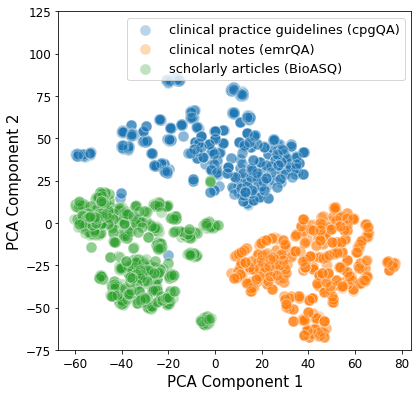

(0,
 array([[  0.98637265,  36.086494  ],
        [-23.95606   ,  60.80466   ],
        [ 10.3429365 ,  47.858917  ],
        ...,
        [-11.097624  ,  -3.7427967 ],
        [-11.08335   ,  -3.7198358 ],
        [-32.136654  , -27.59761   ]], dtype=float32),
 array([0, 0, 0, ..., 2, 2, 2]))

In [105]:
n_init = 5
max_iter = 80 #90
eps_mds = 0.01

count = 0
eps = 0.002
min_samples = 20 #20

clustering(eps, n_init, max_iter, eps_mds, min_samples, model,
               dataset_list, domains, sample_size, BASE_MODEL=False, pca_data=None)

Evaluating: 100%|██████████| 938/938 [00:09<00:00, 98.18it/s]


MDS completed . . . .
(1124256, 2) (1124256, 2)
DBSCAN completed . . . .
data.shape:  (1367, 2)
data.shape:  (1121951, 2)
data.shape:  (938, 2)


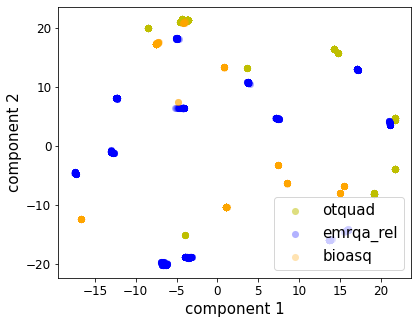

In [13]:
n_init = 5
max_iter = 80 #90
eps_mds = 0.01

count = 0
eps = 0.002
min_samples = 20 #20

_, data_all, label_all = clustering(eps, n_init, max_iter, eps_mds,
                                    min_samples, model,
                                    dataset_list, domains, sample_size,
                                    BASE_MODEL=False, pca_data=None)

# check model architecture

BioLinkBERT - uncased
PubMedBERT - uncased 
BioELECTRA - cased
BioBERT - cased
Scibert - uncased
ClinicalBERT - cased
RoBERTa - cased
BlueBERT - cased
BERT base - uncased

In [121]:
model_ls = [
  'michiyasunaga/BioLinkBERT-base',
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
  'kamalkraj/bioelectra-base-discriminator-pubmed-pmc-lt',
  'dmis-lab/biobert-base-cased-v1.1',
  'allenai/scibert_scivocab_uncased',
  'emilyalsentzer/Bio_ClinicalBERT',
  'roberta-base',
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12',
  'bert-base-uncased'
]

In [118]:
# for i, x in enumerate(model_ls):
#   if i != 2:
#     print(AutoModelForQuestionAnswering.from_pretrained(x).bert.embeddings.word_embeddings)
#   else:
#     print(AutoModelForQuestionAnswering.from_pretrained(x).electra.embeddings.word_embeddings)


In [122]:
for i, x in enumerate(model_ls):
    print(AutoConfig.from_pretrained(x))


BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28895
}

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0

In [124]:
# AutoModelForQuestionAnswering.from_pretrained('roberta-base')